## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 63.3MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 正規化

In [ ]:
import os
import random
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="number"), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42
                                                    ) 

In [ ]:
# 欠損値の除去
X_train = X_train.fillna(X_train.median())
X_train = X_train.dropna(axis=1)

X_test = X_test.fillna(X_test.median())
X_test = X_test.dropna(axis=1)

## 標準化・正規化前

In [ ]:
# データセットを登録
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [ ]:
params = {
          'task': 'train',                      # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          }

In [ ]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[47]	Train's rmse: 0.186339	Test's rmse: 0.242908


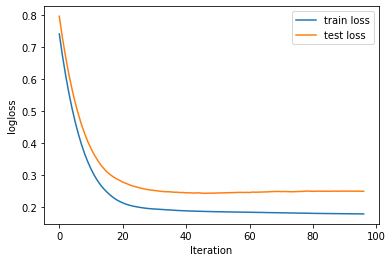

In [ ]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(rmse)

0.24290787668071306


## 標準化後

In [ ]:
sc = StandardScaler()

In [ ]:
X_train_sc = pd.DataFrame(
                            sc.fit_transform(X_train),
                            columns=X_train.columns
                            )

In [ ]:
X_test_sc = pd.DataFrame(
                            sc.transform(X_test),
                            columns=X_test.columns
                            )

In [ ]:
# データセットを登録
lgb_train_sc = lgb.Dataset(X_train_sc, y_train)
lgb_test_sc = lgb.Dataset(X_test_sc, y_test, reference=lgb_train_sc)

In [ ]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train_sc,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train_sc, lgb_test_sc], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[48]	Train's rmse: 0.185752	Test's rmse: 0.242391


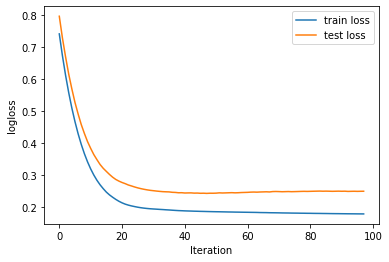

In [ ]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test_sc)

rmse_sc = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_sc)

0.24239129822702232


## 標準化

In [ ]:
nl = MinMaxScaler()

In [ ]:
X_train_mm = pd.DataFrame(
                            nl.fit_transform(X_train),
                            columns=X_train.columns
                            )

In [ ]:
X_test_mm = pd.DataFrame(
                            nl.transform(X_test),
                            columns=X_test.columns
                            )

In [ ]:
# データセットを登録
lgb_train_mm = lgb.Dataset(X_train_mm, y_train)
lgb_test_mm = lgb.Dataset(X_test_mm, y_test, reference=lgb_train_mm)

In [ ]:
lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train_mm,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train_mm, lgb_test_mm], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182075	Test's rmse: 0.254707


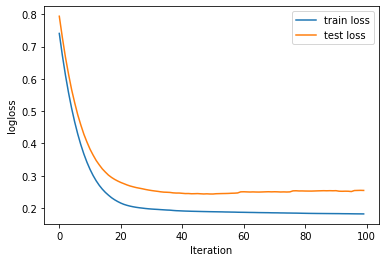

In [ ]:
### 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test_mm)

rmse_mm = mean_squared_error(y_test, y_pred, squared=False)
print(rmse_mm)

0.25470676902648787


In [ ]:
print("標準化・正規化前 RMSE:", round(rmse, 4))
print("標準化後 RMSE:", round(rmse_sc, 4))
print("正規化後 RMSE:", round(rmse_mm, 4))

標準化・正規化前 RMSE: 0.2429
標準化後 RMSE: 0.2424
正規化後 RMSE: 0.2547
